CS 418: Final Project - Classification

Authors: Anusha Sagi, Fatima Kahack, Lydia Tse

Description: In this code, we will be utilizing regression to determine the poverty and child poverty of a specified county


In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error
import math

In [2]:
# Load Election dataset
data_census = pd.read_csv('train_dp_output.csv')
data_census.head()

,Unnamed: 0,CountyId,State,County,TotalPop,Percent_Women,Hispanic,White,Black,Income,...,WorkAtHome,MeanCommute,PrivateWork,PublicWork,SelfEmployed,Unemployment,Poverty,ChildPoverty,Poverty Category,Child_Poverty Category
0,0,1001,Alabama,Autauga County,55036.0,51.124718,2.7,75.4,18.9,55317,...,2.5,25.8,74.1,20.2,5.6,5.2,13.7,20.1,0,0
1,1,1003,Alabama,Baldwin County,203360.0,51.058714,4.4,83.1,9.5,52562,...,5.6,27.0,80.7,12.9,6.3,5.5,11.8,16.1,0,0
2,2,1007,Alabama,Bibb County,22580.0,45.744021,2.4,74.6,22.0,43404,...,1.5,30.0,76.0,17.4,6.3,8.2,15.2,26.6,0,1
3,3,1009,Alabama,Blount County,57667.0,50.595661,9.0,87.4,1.5,47412,...,2.1,35.0,83.9,11.9,4.0,4.9,15.6,25.4,0,1
4,4,1011,Alabama,Bullock County,10478.0,46.401985,0.3,21.6,75.6,29655,...,3.0,29.8,81.4,13.6,5.0,12.1,28.5,50.4,1,1


In [3]:
#Remove unnamed first column
data_census = data_census.loc[:, ~data_census.columns.str.contains('^Unnamed')]
data_census.head()

,CountyId,State,County,TotalPop,Percent_Women,Hispanic,White,Black,Income,IncomePerCap,...,WorkAtHome,MeanCommute,PrivateWork,PublicWork,SelfEmployed,Unemployment,Poverty,ChildPoverty,Poverty Category,Child_Poverty Category
0,1001,Alabama,Autauga County,55036.0,51.124718,2.7,75.4,18.9,55317,27824,...,2.5,25.8,74.1,20.2,5.6,5.2,13.7,20.1,0,0
1,1003,Alabama,Baldwin County,203360.0,51.058714,4.4,83.1,9.5,52562,29364,...,5.6,27.0,80.7,12.9,6.3,5.5,11.8,16.1,0,0
2,1007,Alabama,Bibb County,22580.0,45.744021,2.4,74.6,22.0,43404,20911,...,1.5,30.0,76.0,17.4,6.3,8.2,15.2,26.6,0,1
3,1009,Alabama,Blount County,57667.0,50.595661,9.0,87.4,1.5,47412,22021,...,2.1,35.0,83.9,11.9,4.0,4.9,15.6,25.4,0,1
4,1011,Alabama,Bullock County,10478.0,46.401985,0.3,21.6,75.6,29655,20856,...,3.0,29.8,81.4,13.6,5.0,12.1,28.5,50.4,1,1


In [4]:
x_train_full, x_validation_full, y_train, y_validation = train_test_split(data_census[['CountyId', 'State', 'County', 'TotalPop', 'Percent_Women', 'Hispanic', 'White', 'Black', 'Income', 'IncomePerCap', 'Professional', 'Service', 'Production', 'Carpool', 'WorkAtHome', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'Unemployment']], data_census['Poverty Category'], test_size = 0.25, random_state = 0)

In [5]:
# Selecting required variables for x_train
x_train = x_train_full.select_dtypes(include=[np.int64,np.float64])
x_train = x_train.iloc[:,1:17]

# Selecting required variables for x_validation
x_validation = x_validation_full.select_dtypes(include=[np.int64,np.float64])
x_validation = x_validation.iloc[:,1:17]

# Standardizing the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_validation_scaled = scaler.transform(x_validation)
x_train_scaled_df = pd.DataFrame(x_train_scaled,index = x_train.index,columns=x_train.columns)
x_validation_scaled_df = pd.DataFrame(x_validation_scaled,index = x_validation.index,columns=x_validation.columns)

In [6]:
x_train_scaled_df.head()

,TotalPop,Percent_Women,Hispanic,White,Black,Income,IncomePerCap,Professional,Service,Production,Carpool,WorkAtHome,PrivateWork,PublicWork,SelfEmployed,Unemployment
1380,-0.118525,0.045865,-0.424669,0.689223,-0.436854,0.351729,0.262281,-0.089405,0.020679,0.311605,-0.525450,-0.722745,0.273757,0.070351,-0.627322,-0.399510
712,-0.204940,0.230015,-0.377088,0.737585,-0.534862,0.566678,0.567576,0.684500,-0.272313,0.465626,-0.828094,-0.486424,0.430169,-0.701345,0.233632,-1.099195
31,0.737568,0.484634,-0.340081,-0.436288,1.075267,0.889286,1.285452,2.232309,-0.778390,-0.903448,-1.197992,-0.452664,0.195551,0.306584,-0.855222,-0.022756
1969,-0.095083,0.500355,0.082856,-0.493443,0.886252,-0.045923,-0.098784,0.123039,-0.591940,0.380059,-1.164364,-0.317624,0.795131,-0.669847,-0.450067,0.165621
655,-0.010013,-0.916455,-0.414095,0.416639,-0.471857,0.251228,0.246021,2.293007,-0.219042,-1.091695,-1.231619,0.087498,-1.146986,1.928721,-0.804578,-0.587887


In [7]:
x_validation_scaled_df.head()

,TotalPop,Percent_Women,Hispanic,White,Black,Income,IncomePerCap,Professional,Service,Production,Carpool,WorkAtHome,PrivateWork,PublicWork,SelfEmployed,Unemployment
2054,-0.266679,-1.052672,1.690019,-1.210077,-0.205836,-0.839971,-1.047797,-0.195627,0.287036,-0.184684,-0.794467,-0.081303,-0.351891,-0.276125,1.170553,-0.184222
743,-0.271908,-0.538295,1.272368,-0.572580,-0.597867,0.607557,-0.164433,0.214087,-1.843815,0.499853,0.819632,-0.283863,-0.404029,-0.354869,1.423774,-0.560976
2298,-0.104267,-0.877347,-0.498683,0.829912,-0.513861,0.440793,0.189490,-0.241151,-0.378855,1.030369,-0.491823,0.425100,0.912440,-1.047821,-0.120879,-0.776263
1534,0.802903,0.416973,-0.350655,0.315519,-0.058824,0.953482,0.603591,1.048690,-0.432127,-0.338705,-0.760840,-0.182583,1.342573,-1.016323,-0.931188,-0.318777
1841,-0.213595,0.389020,-0.466963,0.746378,-0.345847,-0.750760,-0.371559,-1.121278,0.260400,1.150163,-1.298873,1.235343,-0.390994,-0.039891,0.841364,0.784573


#                                    MODELS FOR POVERTY 



---

# Classification Model Used: Decision Tree Classifier 


MODEL 1 

    - Variables used: All

In [8]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [9]:
# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 110,  5, -0.36439811, 0.97615296, 1820, 1.820e+03)
 (  2,  33,  6, -0.61880383, 0.62753397,  668, 6.680e+02)
 (  3,   8, 15, -0.81662986, 0.25363946,  400, 4.000e+02)
 (  4,   7,  5, -0.65712106, 0.99403021,   11, 1.100e+01)
 (  5,   6,  1, -2.01887672, 0.65002242,    6, 6.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    5, 5.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    5, 5.000e+00)
 (  9,  10,  5, -0.99544594, 0.18567934,  389, 3.890e+02)
 ( -1,  -1, -2, -2.        , 0.        ,  188, 1.880e+02)
 ( 11,  26,  1, -0.1501097 , 0.30614466,  201, 2.010e+02)
 ( 12,  19, 11, -0.85778576, 0.57258047,   59, 5.900e+01)
 ( 13,  14,  4, -0.04832312, 0.97986876,   12, 1.200e+01)
 ( -1,  -1, -2, -2.        , 0.        ,    4, 4.000e+00)
 ( 15,  18,  3, -0.22305617, 0.954434  ,    8, 8.000e+00)
 ( 16,  17, 15,  0.90567267, 0.81127812,    4, 4.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    3, 3.000e+00)
 ( -1,  -1, -2

295

In [10]:
y_pred = classifier.predict(x_validation_scaled_df)

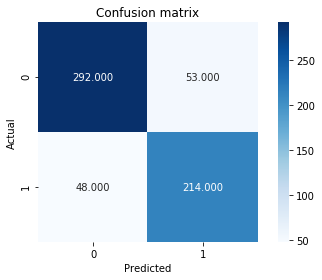

In [11]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [12]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8336079077429983, 0.1663920922570017, array([0.85882353, 0.80149813]), array([0.84637681, 0.81679389]), array([0.85255474, 0.80907372])]


---

MODEL 2

    -Variables Used: Hispanic, White, Black, Percent_Women

In [13]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df[['Hispanic', 'White', 'Black', 'Percent_Women']], y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [14]:
# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 234,  1, -2.51633614e-01, 0.97615296, 1820, 1.820e+03)
 (  2,  67,  0, -3.05717692e-01, 0.89440709,  569, 5.690e+02)
 (  3,  40,  2,  1.36229038e+00, 0.52424171,  203, 2.030e+02)
 (  4,   5,  3, -1.68634611e+00, 0.82465783,   58, 5.800e+01)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    3, 3.000e+00)
 (  6,   7,  0, -5.14543146e-01, 0.75683363,   55, 5.500e+01)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    7, 7.000e+00)
 (  8,   9,  0, -4.93396252e-01, 0.81127812,   48, 4.800e+01)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    2, 2.000e+00)
 ( 10,  11,  0, -4.59032580e-01, 0.75537541,   46, 4.600e+01)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    6, 6.000e+00)
 ( 12,  39,  0, -3.16291109e-01, 0.81127812,   40, 4.000e+01)
 ( 13,  24,  0, -3.48011449e-01, 0.86312057,   35, 3.500e+01)
 ( 14,  15,  1, -4.71460015e-01, 0.68403844,   22, 2.200e+01)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    9, 9.000e+00)
 ( 16,  23,  3,  6.80638671e-01, 0.89049164,   13, 1.300e+01)
 ( 17,  

879

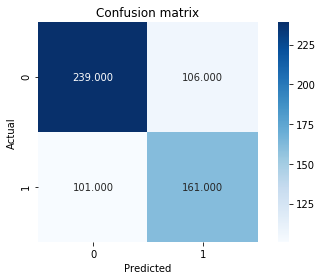

In [15]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic', 'White', 'Black', 'Percent_Women']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [16]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.6589785831960461, 0.3410214168039539, array([0.70294118, 0.60299625]), array([0.69275362, 0.61450382]), array([0.69781022, 0.60869565])]


---

MODEL 3

    -Variables Used: Unemployment, Income, SelfEmployed

In [17]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df[['Unemployment', 'Income', 'SelfEmployed']], y_train)


# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 192,  1, -0.36439811, 0.97615296, 1820, 1.820e+03)
 (  2,  47,  1, -0.72862309, 0.62753397,  668, 6.680e+02)
 (  3,   8,  1, -0.99544594, 0.23373142,  367, 3.670e+02)
 (  4,   7,  0, -1.2472055 , 0.04484961,  203, 2.030e+02)
 (  5,   6,  0, -1.5701372 , 1.        ,    2, 2.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,  201, 2.010e+02)
 (  9,  38,  2,  1.22119701, 0.39959571,  164, 1.640e+02)
 ( 10,  11,  1, -0.99367499, 0.32275696,  153, 1.530e+02)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( 12,  37,  1, -0.77514738, 0.29747225,  152, 1.520e+02)
 ( 13,  36,  1, -0.77562702, 0.35764671,  118, 1.180e+02)
 ( 14,  15,  2, -0.61466122, 0.32676598,  117, 1.170e+02)
 ( -1,  -1, -2, -2.        , 0.        ,   38, 3.800e+01)
 ( 16,  21,  0, -0.21113288, 0.43180499,   79, 7.900e+01)
 ( 17,  18,  0, -0.33223227, 0.84535094,   11, 1.100e+01)
 ( -1,  -1, -2

577

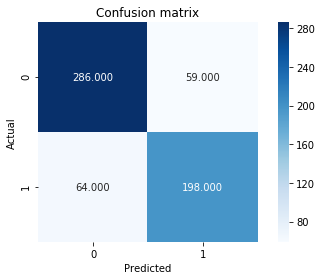

In [18]:
y_pred = classifier.predict(x_validation_scaled_df[['Unemployment', 'Income', 'SelfEmployed']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [19]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7973640856672158, 0.20263591433278416, array([0.81714286, 0.77042802]), array([0.82898551, 0.75572519]), array([0.82302158, 0.76300578])]


---

MODEL 4 

    -Variables Used: Hispanic, Black, White, Percent_Women, Unemployment, Income, SelfEmployment

In [20]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White', 'Percent_Women', 'Unemployment', 'Income', 'SelfEmployed']], y_train)


# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 162,  5, -0.36439811, 0.97615296, 1820, 1.820e+03)
 (  2,  41,  5, -0.72862309, 0.62753397,  668, 6.680e+02)
 (  3,   8,  5, -0.99544594, 0.23373142,  367, 3.670e+02)
 (  4,   7,  4, -1.2472055 , 0.04484961,  203, 2.030e+02)
 (  5,   6,  6, -1.33634338, 1.        ,    2, 2.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,  201, 2.010e+02)
 (  9,  36,  3,  1.40783721, 0.39959571,  164, 1.640e+02)
 ( 10,  17,  3, -1.88811851, 0.34037329,  158, 1.580e+02)
 ( 11,  12,  0, -0.32422119, 0.86312057,   14, 1.400e+01)
 ( -1,  -1, -2, -2.        , 0.        ,    7, 7.000e+00)
 ( 13,  16,  3, -2.41706753, 0.98522814,    7, 7.000e+00)
 ( 14,  15,  4, -0.0631225 , 0.81127812,    4, 4.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    3, 3.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    3, 3.000e+00)
 ( 18,  19,  5

405

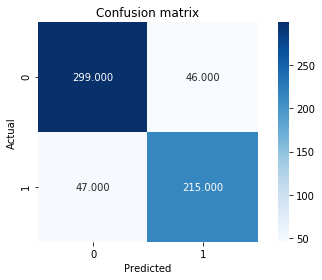

In [21]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White', 'Percent_Women','Unemployment', 'Income', 'SelfEmployed']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [22]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8467874794069192, 0.15321252059308077, array([0.86416185, 0.82375479]), array([0.86666667, 0.82061069]), array([0.86541245, 0.82217973])]


---

MODEL 5

    - Variables Used: Hispanic, Black, White, Percent_Women, Unemployment, Income, SelfEmployed, Professional

In [23]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White', 'Percent_Women' ,'Unemployment', 'Income','SelfEmployed','Professional']], y_train)


# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 160,  5, -0.36439811, 0.97615296, 1820, 1.820e+03)
 (  2,  41,  5, -0.72862309, 0.62753397,  668, 6.680e+02)
 (  3,   8,  5, -0.99544594, 0.23373142,  367, 3.670e+02)
 (  4,   7,  4, -1.2472055 , 0.04484961,  203, 2.030e+02)
 (  5,   6,  0,  3.92101538, 1.        ,    2, 2.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,  201, 2.010e+02)
 (  9,  36,  3,  1.40783721, 0.39959571,  164, 1.640e+02)
 ( 10,  17,  3, -1.88811851, 0.34037329,  158, 1.580e+02)
 ( 11,  12,  0, -0.32422119, 0.86312057,   14, 1.400e+01)
 ( -1,  -1, -2, -2.        , 0.        ,    7, 7.000e+00)
 ( 13,  14,  0, -0.16033287, 0.98522814,    7, 7.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    3, 3.000e+00)
 ( 15,  16,  5, -0.85709062, 0.81127812,    4, 4.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    3, 3.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( 18,  19,  5

375

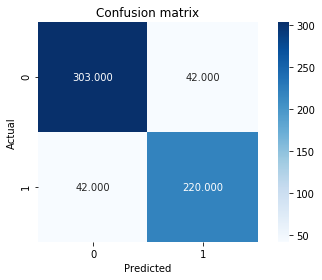

In [24]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White','Percent_Women','Unemployment','Income','SelfEmployed', 'Professional']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [25]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8616144975288303, 0.13838550247116965, array([0.87826087, 0.83969466]), array([0.87826087, 0.83969466]), array([0.87826087, 0.83969466])]


----

MODEL 6

    -Variables Used: Hispanic, Black, White, Unemployment, Income, SelfEmployed, Professional

In [26]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White' ,'Unemployment', 'Income','SelfEmployed','Professional']], y_train)



# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 158,  4, -0.36439811, 0.97615296, 1820, 1.820e+03)
 (  2,  43,  4, -0.72862309, 0.62753397,  668, 6.680e+02)
 (  3,   8,  4, -0.99544594, 0.23373142,  367, 3.670e+02)
 (  4,   7,  3, -1.2472055 , 0.04484961,  203, 2.030e+02)
 (  5,   6,  6, -0.90124612, 1.        ,    2, 2.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,  201, 2.010e+02)
 (  9,  36,  5,  1.22119701, 0.39959571,  164, 1.640e+02)
 ( 10,  35,  1,  3.46595979, 0.32275696,  153, 1.530e+02)
 ( 11,  34,  4, -0.8283127 , 0.29747225,  152, 1.520e+02)
 ( 12,  31,  4, -0.83218664, 0.40790598,   98, 9.800e+01)
 ( 13,  14,  4, -0.99367499, 0.33985508,   95, 9.500e+01)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( 15,  22,  3, -0.22458837, 0.29980251,   94, 9.400e+01)
 ( 16,  17,  3, -0.33223227, 0.67229482,   17, 1.700e+01)
 ( -1,  -1, -2, -2.        , 0.        ,   10, 1.000e+01)
 ( 18,  19,  5

381

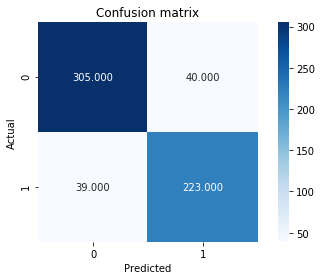

In [27]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White','Unemployment','Income','SelfEmployed', 'Professional']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [28]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8698517298187809, 0.1301482701812191, array([0.88662791, 0.84790875]), array([0.88405797, 0.85114504]), array([0.88534107, 0.84952381])]


---

# Classification Model Used: K-Nearest Neighbors

MODEL 1

    - Variables: Hispanic, Black, White, Unmployment, Income, SelfEmployed, Professional
    - K = 5 

In [29]:
classifier = KNeighborsClassifier(n_neighbors = 5)  
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White' ,'Unemployment', 'Income','SelfEmployed','Professional']], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

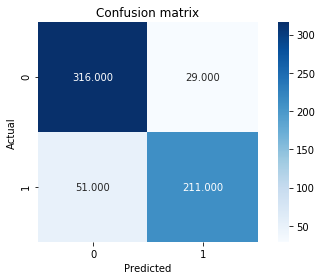

In [30]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White','Unemployment','Income','SelfEmployed', 'Professional']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [31]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8682042833607908, 0.1317957166392092, array([0.86103542, 0.87916667]), array([0.91594203, 0.80534351]), array([0.88764045, 0.84063745])]


---

MODEL 2 

    - Variables: Hispanic, Black, White, Unmployment, Income, SelfEmployed, Professional
    - K = 7 

In [32]:
classifier = KNeighborsClassifier(n_neighbors = 7)  
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White' ,'Unemployment', 'Income','SelfEmployed','Professional']], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

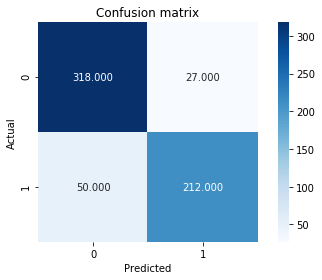

In [33]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White','Unemployment','Income','SelfEmployed', 'Professional']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [34]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8731466227347611, 0.12685337726523893, array([0.86413043, 0.88702929]), array([0.92173913, 0.80916031]), array([0.89200561, 0.84630739])]


---

MODEL 3 

    - Variables: Hispanic, Black, White, Percent_Women, Unemployment, Income, SelfEmployed, Professional
    - K = 7

In [35]:
classifier = KNeighborsClassifier(n_neighbors = 7)  
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White' ,'Percent_Women','Unemployment', 'Income','SelfEmployed','Professional']], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

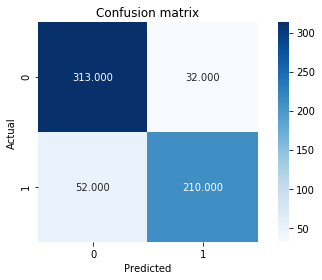

In [36]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White','Percent_Women','Unemployment','Income','SelfEmployed', 'Professional']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [37]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8616144975288303, 0.13838550247116965, array([0.85753425, 0.8677686 ]), array([0.90724638, 0.80152672]), array([0.88169014, 0.83333333])]


---

MODEL 4 

    - Variables: Hispanic, Black, White, Percent_Women
    - K = 7

In [38]:
classifier = KNeighborsClassifier(n_neighbors = 7)  
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White' ,'Percent_Women']], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

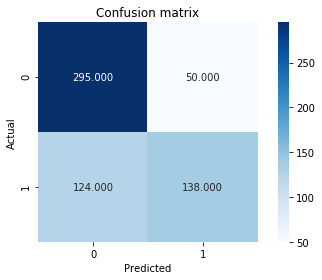

In [39]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White','Percent_Women']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [40]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.71334431630972, 0.28665568369028005, array([0.70405728, 0.73404255]), array([0.85507246, 0.52671756]), array([0.77225131, 0.61333333])]


----

MODEL 5 

    - Variables: Unemployment, Income, SelfEmployed, Professional
    - K = 7

In [41]:
classifier = KNeighborsClassifier(n_neighbors = 7)  
classifier.fit(x_train_scaled_df[['Unemployment', 'Income','SelfEmployed','Professional']], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

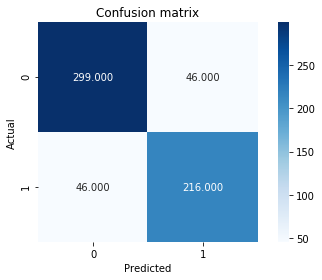

In [42]:
y_pred = classifier.predict(x_validation_scaled_df[['Unemployment','Income','SelfEmployed', 'Professional']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [43]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8484349258649094, 0.15156507413509057, array([0.86666667, 0.82442748]), array([0.86666667, 0.82442748]), array([0.86666667, 0.82442748])]


-----

MODEL 6 

    - Variables: Percent_Women, Unemployment, Income, SelfEmployed, Professional
    - K = 7

In [44]:
classifier = KNeighborsClassifier(n_neighbors = 7)  
classifier.fit(x_train_scaled_df[['Percent_Women','Unemployment', 'Income','SelfEmployed','Professional']], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

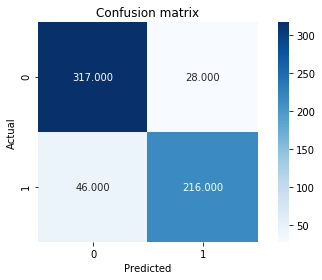

In [45]:
y_pred = classifier.predict(x_validation_scaled_df[['Percent_Women','Unemployment','Income','SelfEmployed', 'Professional']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [46]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8780889621087314, 0.12191103789126856, array([0.87327824, 0.8852459 ]), array([0.91884058, 0.82442748]), array([0.89548023, 0.85375494])]


----

# Classification Model Used: Support Vector Machines

---

MODEL 1

    -Variables Used: All

In [47]:
classifier = SVC(kernel = 'rbf')  
classifier.fit(x_train_scaled_df, y_train)
y_pred = classifier.predict(x_validation_scaled_df)

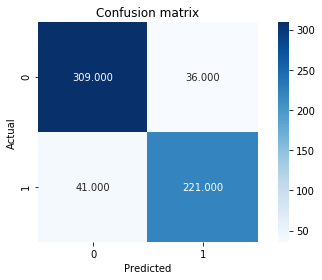

In [48]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [49]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8731466227347611, 0.12685337726523893, array([0.88285714, 0.85992218]), array([0.89565217, 0.84351145]), array([0.88920863, 0.85163776])]


----

MODEL 2

    - Variables Used: Hispanic, White, Black

In [50]:
classifier = SVC(kernel = 'rbf')  
classifier.fit(x_train_scaled_df[['Hispanic', 'White', 'Black']], y_train)
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic', 'White', 'Black']])

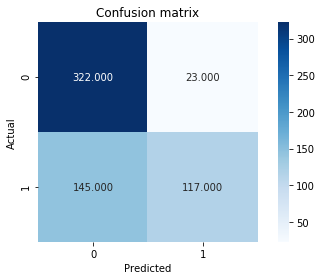

In [51]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [52]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7232289950576606, 0.2767710049423394, array([0.68950749, 0.83571429]), array([0.93333333, 0.44656489]), array([0.79310345, 0.58208955])]


----

MODEL 3

    -Variables Used: Hispanic, White, Black, Percent_Women

In [53]:
classifier = SVC(kernel = 'rbf')
classifier.fit(x_train_scaled_df[['Hispanic', 'White', 'Black', 'Percent_Women']], y_train)
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic', 'White', 'Black', 'Percent_Women']])

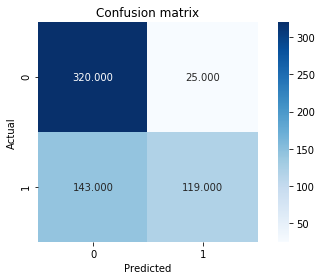

In [54]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [55]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7232289950576606, 0.2767710049423394, array([0.69114471, 0.82638889]), array([0.92753623, 0.45419847]), array([0.79207921, 0.5862069 ])]


-----

MODEL 4

    -Variables Used: Unemployment, Income, SelfEmployed

In [56]:
classifier = SVC(kernel = 'rbf')
classifier.fit(x_train_scaled_df[['Unemployment', 'Income', 'SelfEmployed']], y_train)
y_pred = classifier.predict(x_validation_scaled_df[['Unemployment', 'Income', 'SelfEmployed']])

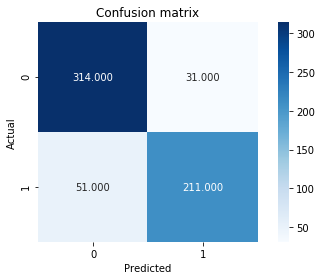

In [57]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [58]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8649093904448105, 0.13509060955518948, array([0.86027397, 0.87190083]), array([0.91014493, 0.80534351]), array([0.88450704, 0.83730159])]


----

MODEL 5

    -Variables Used: Unemployment, Income, SelfEmployed, Black, White, Hispanic, Percent_Women

In [59]:
classifier = SVC(kernel = 'rbf')
classifier.fit(x_train_scaled_df[['Unemployment', 'Income', 'SelfEmployed', 'Black', 'White', 'Hispanic', 'Percent_Women']], y_train)
y_pred = classifier.predict(x_validation_scaled_df[['Unemployment', 'Income', 'SelfEmployed', 'Black', 'White', 'Hispanic', 'Percent_Women']])

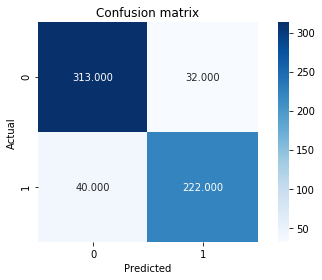

In [60]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [61]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8813838550247117, 0.11861614497528827, array([0.88668555, 0.87401575]), array([0.90724638, 0.84732824]), array([0.89684814, 0.86046512])]


-----

MODEL 6 

    -Variables Used: Unemployment, Income, SelfEmployed, Black, White, Hispanic, Percent_Women, Professional

In [62]:
classifier_poverty = SVC(kernel = 'rbf')
classifier_poverty.fit(x_train_scaled_df[['Unemployment', 'Income', 'SelfEmployed', 'Black', 'White', 'Hispanic', 'Percent_Women', 'Professional']], y_train)
y_pred = classifier_poverty.predict(x_validation_scaled_df[['Unemployment', 'Income', 'SelfEmployed', 'Black', 'White', 'Hispanic', 'Percent_Women', 'Professional']])

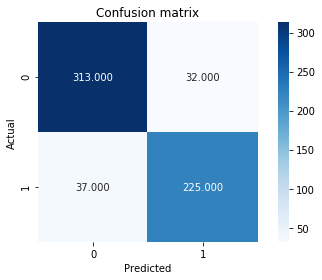

In [63]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [64]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.886326194398682, 0.11367380560131801, array([0.89428571, 0.87548638]), array([0.90724638, 0.85877863]), array([0.90071942, 0.86705202])]


BEST MODELS FOR Poverty Variable

    - The best model for Decision Tree classifier is MODEL 6 with accuracy of 0.87. The variables used in this model are Hispanic, Black, 
      White, Unemployment, Income, SelfEmployed, Professional.
      
    - The best model for K-Nearest Neighbors classifier is MODEL 6 with accuracy of 0.88. The variables used in this model are Percent_Women, 
      Unemployment, Income, SelfEmployed, Professional.
      
    - The best model for Support Vector Machines is MODEL 6 with accuracy of 0.89. The variables used in this model are Unemployment, Income, 
      SelfEmployed, Black, White, Hispanic, Percent_Women,Professional.
      
We could observe that the shared variables for each of the models are Income, Unemployment, and SelfEmployed. The model that performs the best contains additional variables Black, White, Hispanic, Percent_Women, and Professional. 

------

#                        MODELS FOR CHILD POVERTY

-----

Prepare data

In [65]:
x_train_full, x_validation_full, y_train, y_validation = train_test_split(data_census[['CountyId', 'State', 'County', 'TotalPop', 'Percent_Women', 'Hispanic', 'White', 'Black', 'Income', 'IncomePerCap', 'Professional', 'Service', 'Production', 'Carpool', 'WorkAtHome', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'Unemployment']], data_census['Child_Poverty Category'], test_size = 0.25, random_state = 0)

In [66]:
# Selecting required variables for x_train
x_train = x_train_full.select_dtypes(include=[np.int64,np.float64])
x_train = x_train.iloc[:,1:17]

x_train.head()

# Selecting required variables for x_validation
x_validation = x_validation_full.select_dtypes(include=[np.int64,np.float64])
x_validation = x_validation.iloc[:,1:17]

# Standardizing the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_validation_scaled = scaler.transform(x_validation)
x_train_scaled_df = pd.DataFrame(x_train_scaled,index = x_train.index,columns=x_train.columns)
x_validation_scaled_df = pd.DataFrame(x_validation_scaled,index = x_validation.index,columns=x_validation.columns)

---

# Classification Model Used: Decision Tree Classifier 

----

MODEL 1 

    - Variables Used: All

In [67]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df, y_train)
# Show the structure of the decision tree classifier
#print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

365

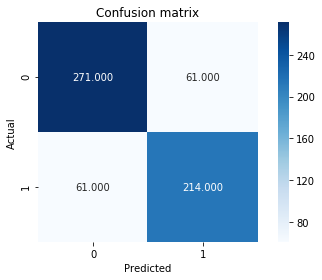

In [68]:
y_pred = classifier.predict(x_validation_scaled_df)
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [69]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7990115321252059, 0.20098846787479407, array([0.81626506, 0.77818182]), array([0.81626506, 0.77818182]), array([0.81626506, 0.77818182])]


-----


MODEL 2

    -Variables Used: Hispanic, White, Black, Percent_Women

In [70]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df[['Hispanic', 'White', 'Black', 'Percent_Women']], y_train)



# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 260,  1, -0.17469436, 0.98612608, 1820, 1.820e+03)
 (  2, 183,  2,  1.08926845, 0.88884602,  604, 6.040e+02)
 (  3,   4,  1, -2.63894856, 0.98019627,  369, 3.690e+02)
 ( -1,  -1, -2, -2.        , 0.        ,   57, 5.700e+01)
 (  5,  34,  1, -1.49804938, 0.99988143,  312, 3.120e+02)
 (  6,   7,  2, -0.60136765, 0.85365767,   61, 6.100e+01)
 ( -1,  -1, -2, -2.        , 0.        ,    2, 2.000e+00)
 (  8,   9,  2, -0.57336539, 0.81792525,   59, 5.900e+01)
 ( -1,  -1, -2, -2.        , 0.        ,   10, 1.000e+01)
 ( 10,  19,  0,  1.22743124, 0.88864667,   49, 4.900e+01)
 ( 11,  12,  0, -0.53040332, 0.9456603 ,   11, 1.100e+01)
 ( -1,  -1, -2, -2.        , 0.        ,    2, 2.000e+00)
 ( 13,  18,  2,  0.93875632, 0.76420451,    9, 9.000e+00)
 ( 14,  15,  0,  0.03263243, 0.54356444,    8, 8.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    5, 5.000e+00)
 ( 16,  17,  1, -1.75524628, 0.91829583,    3, 3.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2

887

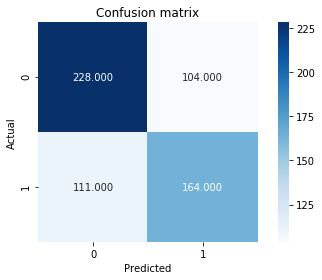

In [71]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic', 'White', 'Black', 'Percent_Women']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [72]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.6457990115321252, 0.35420098846787484, array([0.67256637, 0.6119403 ]), array([0.68674699, 0.59636364]), array([0.67958271, 0.60405157])]


----

MODEL 3

    -Variables Used: Unemployment, Income, SelfEmployed

In [73]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df[['Unemployment', 'SelfEmployed', 'Income']], y_train)


# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 330,  2, -2.12834463e-01, 0.98612608, 1820, 1.820e+03)
 (  2,  29,  2, -9.29847062e-01, 0.77786044,  809, 8.090e+02)
 (  3,  28,  0,  7.17295825e-01, 0.1854148 ,  248, 2.480e+02)
 (  4,  27,  0,  6.90384835e-01, 0.34626857,  108, 1.080e+02)
 (  5,  18,  1, -5.89339018e-01, 0.31166199,  107, 1.070e+02)
 (  6,  11,  2, -1.00326765e+00, 0.55477816,   31, 3.100e+01)
 (  7,  10,  0, -1.00500667e+00, 0.25801867,   23, 2.300e+01)
 (  8,   9,  1, -1.33634338e+00, 1.        ,    2, 2.000e+00)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,   21, 2.100e+01)
 ( 12,  17,  2, -9.60543483e-01, 0.954434  ,    8, 8.000e+00)
 ( 13,  16,  2, -9.79913235e-01, 0.81127812,    4, 4.000e+00)
 ( 14,  15,  0,  1.11798845e-01, 1.        ,    2, 2.000e+00)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    1, 1.000e+00)
 ( -1,  

673

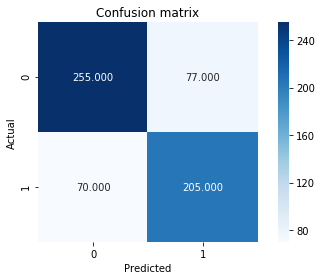

In [74]:
y_pred = classifier.predict(x_validation_scaled_df[['Unemployment', 'SelfEmployed', 'Income']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [75]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7578253706754531, 0.24217462932454692, array([0.78461538, 0.72695035]), array([0.76807229, 0.74545455]), array([0.77625571, 0.73608618])]


----

MODEL 4

    -Variables Used: Hispanic, Black, White, Percent_Women, Unemployment, Income, SelfEmployment

In [76]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White', 'Percent_Women', 'Unemployment', 'Income', 'SelfEmployed']], y_train)



# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 226,  5, -0.21283446, 0.98612608, 1820, 1.820e+03)
 (  2,  25,  5, -0.92984706, 0.77786044,  809, 8.090e+02)
 (  3,  24,  4,  0.71729583, 0.1854148 ,  248, 2.480e+02)
 (  4,   5,  0, -0.43788569, 0.34626857,  108, 1.080e+02)
 ( -1,  -1, -2, -2.        , 0.        ,   59, 5.900e+01)
 (  6,   7,  1, -0.58036596, 0.59167278,   49, 4.900e+01)
 ( -1,  -1, -2, -2.        , 0.        ,   14, 1.400e+01)
 (  8,   9,  5, -1.69002646, 0.72192809,   35, 3.500e+01)
 ( -1,  -1, -2, -2.        , 0.        ,    2, 2.000e+00)
 ( 10,  15,  6, -0.8932052 , 0.61361902,   33, 3.300e+01)
 ( 11,  12,  1,  0.41721437, 0.97095059,    5, 5.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    2, 2.000e+00)
 ( 13,  14,  4,  0.13870982, 0.91829583,    3, 3.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    2, 2.000e+00)
 ( 16,  17,  2,  0.07151122, 0.37123233,   28, 2.800e+01)
 ( -1,  -1, -2, -2.        , 0.        ,   19, 1.900e+01)
 ( 18,  23,  1

435

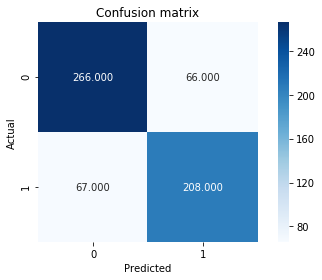

In [77]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White', 'Percent_Women','Unemployment', 'Income', 'SelfEmployed']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [78]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7808896210873146, 0.21911037891268537, array([0.7987988 , 0.75912409]), array([0.80120482, 0.75636364]), array([0.8       , 0.75774135])]


----

MODEL 5 

    -Variables Used: Hispanic, Black, White, Unemployment, Income, SelfEmployment

In [79]:
classifier = DecisionTreeClassifier(criterion = "entropy", splitter="best", min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White','Unemployment', 'Income', 'SelfEmployed', 'WorkAtHome', 'PublicWork']], y_train)


# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1, 216,  4, -2.12834463e-01, 0.98612608, 1820, 1.820e+03)
 (  2,  19,  4, -9.29847062e-01, 0.77786044,  809, 8.090e+02)
 (  3,  18,  3,  7.17295825e-01, 0.1854148 ,  248, 2.480e+02)
 (  4,   5,  0, -4.37885687e-01, 0.34626857,  108, 1.080e+02)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,   59, 5.900e+01)
 (  6,   7,  1, -5.80365956e-01, 0.59167278,   49, 4.900e+01)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,   14, 1.400e+01)
 (  8,   9,  4, -1.69002646e+00, 0.72192809,   35, 3.500e+01)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    2, 2.000e+00)
 ( 10,  15,  6, -8.57785761e-01, 0.61361902,   33, 3.300e+01)
 ( 11,  14,  2, -1.03149563e-03, 0.99107606,    9, 9.000e+00)
 ( 12,  13,  5, -9.94493961e-01, 0.65002242,    6, 6.000e+00)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    5, 5.000e+00)
 ( -1,  -1, -2, -2.00000000e+00, 0.        ,    3, 3.000e+00)
 ( 16,  17,  7, -8.82457525e-01, 0.24988229,   24, 2.400e+01)
 ( -1,  

411

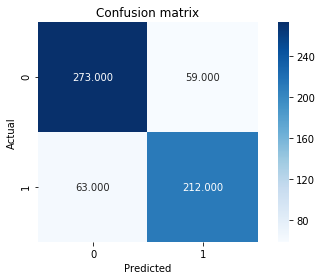

In [80]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black','White','Unemployment', 'Income', 'SelfEmployed', 'WorkAtHome', 'PublicWork']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [81]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7990115321252059, 0.20098846787479407, array([0.8125    , 0.78228782]), array([0.82228916, 0.77090909]), array([0.81736527, 0.77655678])]


------

# Classification Model Used: K-Nearest Neighbors

---

MODEL 1
        
    - Variables Used: All
    - K = 13

In [82]:
classifier = KNeighborsClassifier(n_neighbors = 13)  
classifier.fit(x_train_scaled_df, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

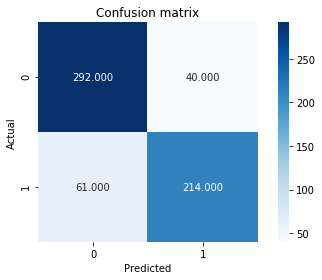

In [83]:
y_pred = classifier.predict(x_validation_scaled_df)
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [84]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8336079077429983, 0.1663920922570017, array([0.82719547, 0.84251969]), array([0.87951807, 0.77818182]), array([0.85255474, 0.80907372])]


------

MODEL 2
    
       - Variables Used: Hispanic, Black, White, Unemployment, Income, SelfEmployed, Professional
       - K = 13

In [85]:
classifier = KNeighborsClassifier(n_neighbors = 13)  
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White' ,'Unemployment', 'Income','SelfEmployed','Professional']], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

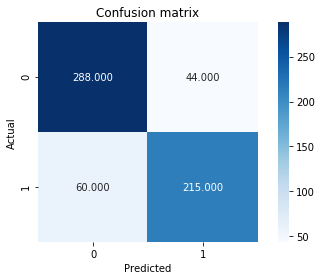

In [86]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White','Unemployment','Income','SelfEmployed', 'Professional']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [87]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.828665568369028, 0.17133443163097195, array([0.82758621, 0.83011583]), array([0.86746988, 0.78181818]), array([0.84705882, 0.80524345])]


--------

MODEL 3

    - Variables Used: Hispanic, Black, White, Percent_Women
    - K = 13 

In [88]:
classifier = KNeighborsClassifier(n_neighbors = 13)  
classifier.fit(x_train_scaled_df[['Hispanic','Black', 'White' ,'Unemployment', 'Percent_Women']], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

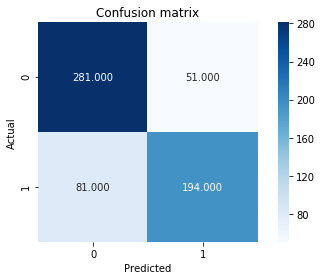

In [89]:
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic','Black', 'White','Unemployment','Percent_Women']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [90]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7825370675453048, 0.21746293245469517, array([0.77624309, 0.79183673]), array([0.84638554, 0.70545455]), array([0.80979827, 0.74615385])]


------

MODEL 4

    - Variables Used: White, Hispanic, Black, Unemployment, Income, WorkAtHome
    - K = 13

In [91]:
classifier_childPoverty = KNeighborsClassifier(n_neighbors = 13)  
classifier_childPoverty.fit(x_train_scaled_df[['White','Hispanic','Black' ,'Unemployment', 'Income', 'WorkAtHome']], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

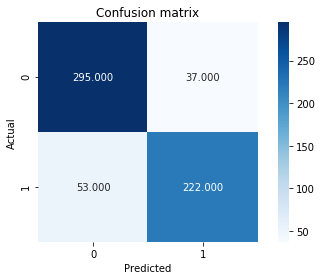

In [92]:
y_pred = classifier_childPoverty.predict(x_validation_scaled_df[['White','Hispanic','Black','Unemployment', 'Income', 'WorkAtHome']])
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [93]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - metrics.accuracy_score(y_validation, y_pred)
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8517298187808896, 0.1482701812191104, array([0.84770115, 0.85714286]), array([0.88855422, 0.80727273]), array([0.86764706, 0.83146067])]


--------

# Classification Model Used: Support Vector Machines

---

MODEL 1

    -Variables Used: All

In [94]:
classifier = SVC(kernel = 'rbf')  
classifier.fit(x_train_scaled_df, y_train)
y_pred = classifier.predict(x_validation_scaled_df)

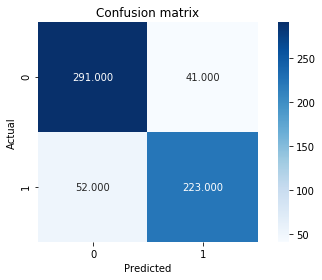

In [95]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [96]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8467874794069192, 0.15321252059308077, array([0.8483965 , 0.84469697]), array([0.87650602, 0.81090909]), array([0.86222222, 0.82745826])]


---------

MODEL 2

    -Variables Used: Hispanic, White, Black

In [97]:
classifier = SVC(kernel = 'rbf')  
classifier.fit(x_train_scaled_df[['Hispanic', 'White', 'Black']], y_train)
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic', 'White', 'Black']])

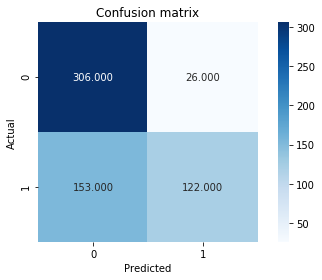

In [98]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [99]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7051070840197694, 0.2948929159802306, array([0.66666667, 0.82432432]), array([0.92168675, 0.44363636]), array([0.77370417, 0.57683215])]


--------

MODEL 3

    -Variables Used: Hispanic, White, Black, Percent_Women

In [100]:
classifier = SVC(kernel = 'rbf')  
classifier.fit(x_train_scaled_df[['Hispanic', 'White', 'Black', 'Percent_Women']], y_train)
y_pred = classifier.predict(x_validation_scaled_df[['Hispanic', 'White', 'Black', 'Percent_Women']])

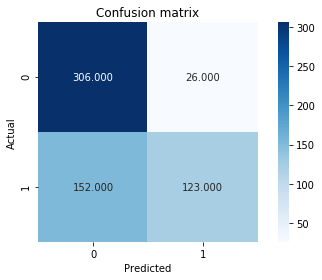

In [101]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [102]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7067545304777595, 0.2932454695222405, array([0.66812227, 0.82550336]), array([0.92168675, 0.44727273]), array([0.77468354, 0.58018868])]


-------

MODEL 4

    - Variables Used: Unemployment, Income, SelfEmployed

In [103]:
classifier = SVC(kernel = 'rbf')  
classifier.fit(x_train_scaled_df[['Unemployment', 'Income', 'SelfEmployed']], y_train)
y_pred = classifier.predict(x_validation_scaled_df[['Unemployment', 'Income', 'SelfEmployed']])

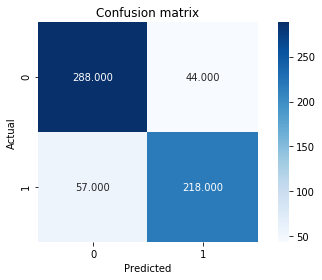

In [104]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [105]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8336079077429983, 0.1663920922570017, array([0.83478261, 0.83206107]), array([0.86746988, 0.79272727]), array([0.85081241, 0.81191806])]


-------

MODEL 5

    Variables Used: Unemployment, Income, White, Black, Hispanic

In [106]:
classifier = SVC(kernel = 'rbf')  
classifier.fit(x_train_scaled_df[['Unemployment', 'Income', 'White', 'Black', 'Hispanic']], y_train)
y_pred = classifier.predict(x_validation_scaled_df[['Unemployment', 'Income', 'White', 'Black', 'Hispanic']])

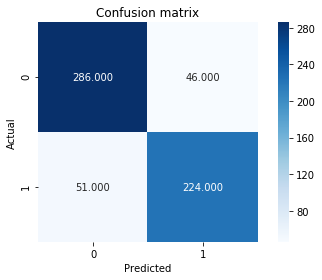

In [107]:
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [108]:
accuracy = metrics.accuracy_score(y_validation, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(y_validation, y_pred, average = None)
recall = metrics.recall_score(y_validation, y_pred, average = None)
F1_score = metrics.f1_score(y_validation, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8401976935749588, 0.15980230642504123, array([0.84866469, 0.82962963]), array([0.86144578, 0.81454545]), array([0.85500747, 0.82201835])]


-----

BEST MODELS FOR Child Poverty Variable

    - The best model for Decision Tree classifier is MODEL 5 with accuracy of 0.80. The variables used in this model are Hispanic, Black, 
      White, Unemployment, Income, SelfEmployment.
      
    - The best model for K-Nearest Neighbors classifier is MODEL 4 with accuracy of 0.85. The variables used in this model are White, Hispanic, 
      Black, Unemployment, Income, WorkAtHome
      
    - The best model for Support Vector Machines is MODEL 1 with accuracy of 0.85. All variables are used in this model. 
      
We could observe that the shared variables for each of the models are Income, Unemployment, Hispanic, Black, and White.

In [109]:
# Load Census test dataset
test_census = pd.read_csv('test_dp_output.csv')
test_census.head()

,Unnamed: 0,CountyId,State,County,TotalPop,Percent_Women,Hispanic,White,Black,Income,...,Professional,Service,Production,Carpool,WorkAtHome,MeanCommute,PrivateWork,PublicWork,SelfEmployed,Unemployment
0,0,1005,Alabama,Barbour County,26201.0,46.658524,4.2,45.7,47.8,33368,...,25.0,16.8,24.1,11.1,1.3,23.4,74.1,19.1,6.5,12.4
1,1,1025,Alabama,Clarke County,24625.0,52.694416,0.2,53.0,45.7,33827,...,21.6,14.3,25.6,11.9,0.9,23.9,83.1,11.8,5.1,15.2
2,2,1037,Alabama,Coosa County,10955.0,50.031949,0.1,65.3,33.2,34792,...,17.6,23.2,20.9,9.7,4.2,29.8,78.8,15.9,5.4,11.3
3,3,1047,Alabama,Dallas County,40755.0,53.848608,1.0,27.7,70.2,30065,...,26.7,18.2,25.3,8.9,1.2,22.1,78.8,15.2,5.6,13.7
4,4,1053,Alabama,Escambia County,37621.0,48.629755,2.2,60.2,32.2,35026,...,24.6,21.2,18.3,7.0,0.8,22.6,75.6,19.7,4.6,13.7


In [110]:
#Remove unnamed first column
test_census = test_census.loc[:, ~test_census.columns.str.contains('^Unnamed')]
test_census.head()

,CountyId,State,County,TotalPop,Percent_Women,Hispanic,White,Black,Income,IncomePerCap,Professional,Service,Production,Carpool,WorkAtHome,MeanCommute,PrivateWork,PublicWork,SelfEmployed,Unemployment
0,1005,Alabama,Barbour County,26201.0,46.658524,4.2,45.7,47.8,33368,17561,25.0,16.8,24.1,11.1,1.3,23.4,74.1,19.1,6.5,12.4
1,1025,Alabama,Clarke County,24625.0,52.694416,0.2,53.0,45.7,33827,20765,21.6,14.3,25.6,11.9,0.9,23.9,83.1,11.8,5.1,15.2
2,1037,Alabama,Coosa County,10955.0,50.031949,0.1,65.3,33.2,34792,20342,17.6,23.2,20.9,9.7,4.2,29.8,78.8,15.9,5.4,11.3
3,1047,Alabama,Dallas County,40755.0,53.848608,1.0,27.7,70.2,30065,18248,26.7,18.2,25.3,8.9,1.2,22.1,78.8,15.2,5.6,13.7
4,1053,Alabama,Escambia County,37621.0,48.629755,2.2,60.2,32.2,35026,18164,24.6,21.2,18.3,7.0,0.8,22.6,75.6,19.7,4.6,13.7


In [111]:
test_census = test_census[['CountyId', 'State', 'County', 'TotalPop', 'Percent_Women', 'Hispanic', 'White', 'Black', 'Income', 'IncomePerCap', 'Professional', 'Service', 'Production', 'Carpool', 'WorkAtHome', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'Unemployment']]
test_census.head()

,CountyId,State,County,TotalPop,Percent_Women,Hispanic,White,Black,Income,IncomePerCap,Professional,Service,Production,Carpool,WorkAtHome,PrivateWork,PublicWork,SelfEmployed,Unemployment
0,1005,Alabama,Barbour County,26201.0,46.658524,4.2,45.7,47.8,33368,17561,25.0,16.8,24.1,11.1,1.3,74.1,19.1,6.5,12.4
1,1025,Alabama,Clarke County,24625.0,52.694416,0.2,53.0,45.7,33827,20765,21.6,14.3,25.6,11.9,0.9,83.1,11.8,5.1,15.2
2,1037,Alabama,Coosa County,10955.0,50.031949,0.1,65.3,33.2,34792,20342,17.6,23.2,20.9,9.7,4.2,78.8,15.9,5.4,11.3
3,1047,Alabama,Dallas County,40755.0,53.848608,1.0,27.7,70.2,30065,18248,26.7,18.2,25.3,8.9,1.2,78.8,15.2,5.6,13.7
4,1053,Alabama,Escambia County,37621.0,48.629755,2.2,60.2,32.2,35026,18164,24.6,21.2,18.3,7.0,0.8,75.6,19.7,4.6,13.7


In [112]:
x_test = test_census.select_dtypes(include=[np.int64,np.float64])
x_test = x_test.iloc[:,1:17]
x_test_scaled = scaler.transform(x_test)
x_test_scaled_df = pd.DataFrame(x_test_scaled,index = x_test.index,columns=x_test.columns)

In [113]:
y_predicted_povertyCat = classifier_poverty.predict(x_test_scaled_df[['Unemployment', 'Income', 'SelfEmployed', 'Black', 'White', 'Hispanic', 'Percent_Women', 'Professional']])
test_census['Poverty Category'] = y_predicted_povertyCat
test_census.head()

,CountyId,State,County,TotalPop,Percent_Women,Hispanic,White,Black,Income,IncomePerCap,Professional,Service,Production,Carpool,WorkAtHome,PrivateWork,PublicWork,SelfEmployed,Unemployment,Poverty Category
0,1005,Alabama,Barbour County,26201.0,46.658524,4.2,45.7,47.8,33368,17561,25.0,16.8,24.1,11.1,1.3,74.1,19.1,6.5,12.4,1
1,1025,Alabama,Clarke County,24625.0,52.694416,0.2,53.0,45.7,33827,20765,21.6,14.3,25.6,11.9,0.9,83.1,11.8,5.1,15.2,1
2,1037,Alabama,Coosa County,10955.0,50.031949,0.1,65.3,33.2,34792,20342,17.6,23.2,20.9,9.7,4.2,78.8,15.9,5.4,11.3,1
3,1047,Alabama,Dallas County,40755.0,53.848608,1.0,27.7,70.2,30065,18248,26.7,18.2,25.3,8.9,1.2,78.8,15.2,5.6,13.7,1
4,1053,Alabama,Escambia County,37621.0,48.629755,2.2,60.2,32.2,35026,18164,24.6,21.2,18.3,7.0,0.8,75.6,19.7,4.6,13.7,1


In [114]:
y_predicted_childPovertyCat = classifier_childPoverty.predict(x_test_scaled_df[['White','Hispanic','Black' ,'Unemployment', 'Income', 'WorkAtHome']])
test_census['Child_Poverty Category'] = y_predicted_childPovertyCat
test_census.head()

,CountyId,State,County,TotalPop,Percent_Women,Hispanic,White,Black,Income,IncomePerCap,...,Service,Production,Carpool,WorkAtHome,PrivateWork,PublicWork,SelfEmployed,Unemployment,Poverty Category,Child_Poverty Category
0,1005,Alabama,Barbour County,26201.0,46.658524,4.2,45.7,47.8,33368,17561,...,16.8,24.1,11.1,1.3,74.1,19.1,6.5,12.4,1,1
1,1025,Alabama,Clarke County,24625.0,52.694416,0.2,53.0,45.7,33827,20765,...,14.3,25.6,11.9,0.9,83.1,11.8,5.1,15.2,1,1
2,1037,Alabama,Coosa County,10955.0,50.031949,0.1,65.3,33.2,34792,20342,...,23.2,20.9,9.7,4.2,78.8,15.9,5.4,11.3,1,1
3,1047,Alabama,Dallas County,40755.0,53.848608,1.0,27.7,70.2,30065,18248,...,18.2,25.3,8.9,1.2,78.8,15.2,5.6,13.7,1,1
4,1053,Alabama,Escambia County,37621.0,48.629755,2.2,60.2,32.2,35026,18164,...,21.2,18.3,7.0,0.8,75.6,19.7,4.6,13.7,1,1


In [115]:
# Load sample output dataset
sample_output = pd.read_excel('sample_output.xlsx')
sample_output.head()

,Unnamed: 0,CountyId,State,County,Poverty,ChildPoverty
0,0,1005,Alabama,Barbour County,27.773252,38.212651
1,1,1025,Alabama,Clarke County,27.235754,40.508661
2,2,1037,Alabama,Coosa County,22.358539,34.926116
3,3,1047,Alabama,Dallas County,31.408525,45.562577
4,4,1053,Alabama,Escambia County,26.052590,36.944246


In [116]:
#Remove unnamed first column
sample_output = sample_output.loc[:, ~sample_output.columns.str.contains('^Unnamed')]
sample_output.head()

,CountyId,State,County,Poverty,ChildPoverty
0,1005,Alabama,Barbour County,27.773252,38.212651
1,1025,Alabama,Clarke County,27.235754,40.508661
2,1037,Alabama,Coosa County,22.358539,34.926116
3,1047,Alabama,Dallas County,31.408525,45.562577
4,1053,Alabama,Escambia County,26.052590,36.944246


In [117]:
sample_output['Poverty Category'] = test_census['Poverty Category']
sample_output['Child_Poverty Category'] = test_census['Child_Poverty Category']
sample_output.head()

,CountyId,State,County,Poverty,ChildPoverty,Poverty Category,Child_Poverty Category
0,1005,Alabama,Barbour County,27.773252,38.212651,1,1
1,1025,Alabama,Clarke County,27.235754,40.508661,1,1
2,1037,Alabama,Coosa County,22.358539,34.926116,1,1
3,1047,Alabama,Dallas County,31.408525,45.562577,1,1
4,1053,Alabama,Escambia County,26.052590,36.944246,1,1


In [118]:
sample_output.to_excel("sample_output.xlsx")